In [1]:
import matplotlib
from datetime import datetime
import pandas as pd
import numpy as np
import boto3
import seaborn as sns
import matplotlib.pyplot as plt

import pickle as pkl
from dotenv import load_dotenv, dotenv_values


In [2]:
pd.options.display.max_columns=100
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
config = dotenv_values(".env")# take environment variables from .env.
key = config['aws_key']
secret = config['aws_secret']
storage_options = { "key": key, "secret": secret}

In [4]:
%load_ext autotime

time: 217 µs (started: 2021-07-13 12:22:16 -07:00)


In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

time: 462 µs (started: 2021-07-13 12:22:16 -07:00)


## Load Data

In [ ]:
email = pd.read_csv('s3://hermanmiller/data/queries/2021_04_01/email_brand_send_dates.csv.gz', 
                 storage_options=storage_options,
                   header=None)

In [ ]:
email

In [7]:
ga = pd.read_csv('/Users/bwassie/Downloads/ga_session_v2_email.csv')
ga.columns = ['month', 'email_transactions']

time: 3.78 ms (started: 2021-07-13 12:22:37 -07:00)


In [8]:
hm = pd.read_csv('/Users/bwassie/Downloads/hm_open_click_order.csv') #contains email sends, clicks, 
hm_email = pd.read_csv('/Users/bwassie/Downloads/hm_email_marketing.csv') #

time: 535 ms (started: 2021-07-13 12:22:38 -07:00)


In [9]:
hm

,EMAIL,SENDS,ORDERS,CLICKS,OPENS
0,laurabanares@hotmail.com,110,1,2,0
1,ashleigh.reeves@gmail.com,85,1,1,0
2,stellarshin0322@gmail.com,202,1,1,0
3,kbmacy@gmail.com,171,1,9,0
4,sha2002@gmail.com,188,1,11,0
...,...,...,...,...,...
17474,alex@lthm.nyc,1,1,0,0
17475,pmcs8@comcast.net,47,1,1,0
17476,saltedrim@gmail.com,7,1,1,0
17477,jassymonet@yahoo.com,6,1,0,0


time: 15.2 ms (started: 2021-07-13 12:22:38 -07:00)


In [10]:
# opens are always 0 - seems to be an error with the query but opens aren't used in calculations so ignoring
hm['OPENS'].describe()

count   17479.00000
mean        0.00000
std         0.00000
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max         0.00000
Name: OPENS, dtype: float64

time: 5.34 ms (started: 2021-07-13 12:22:38 -07:00)


In [11]:
# this is for all customers
hm_email

,EMAIL,NUM_SENDS,NUM_CLICKS,NUM_OPENS
0,tparker@mgpartnersinc.com,175,3,0
1,jane1@esneuro.net,197,3,0
2,susamcm@gmail.com,198,2,0
3,jessica.caruh@gmail.com,162,0,0
4,firshad@tulane.edu,28,3,0
...,...,...,...,...
1008101,sm22ballet@yahoo.com,1,0,0
1008102,carin416@gmail.com,1,0,0
1008103,louis@landrydesign.net,1,0,0
1008104,brooks.niqua@gmail.com,1,0,0


time: 8.39 ms (started: 2021-07-13 12:22:39 -07:00)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


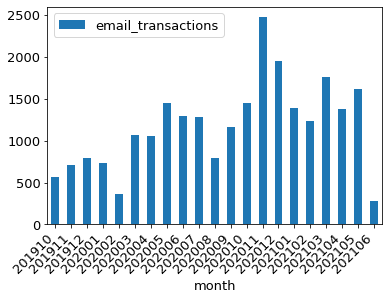

time: 267 ms (started: 2021-07-13 12:22:39 -07:00)


In [12]:
# distribution of transactions from GA by month - just checking if there are any weird patterns
fig, ax = plt.subplots()
ga.sort_values('month').plot.bar(x='month', y='email_transactions', ax=ax)
plt.xticks(rotation=45, ha='right')
fig.patch.set_facecolor('white')
plt.show()


In [13]:
# load clusters from re-segmented model
clusters = pkl.load(open('clusters.pkl', 'rb'))

time: 2.1 ms (started: 2021-07-13 12:22:41 -07:00)


In [14]:
#load pre-covid RFM segmentation dataset
rfm_pre_covid = pd.read_csv('rfm_pre_covid.csv', index_col=0)
rfm_pre_covid['segments'] = clusters
rfm_pre_covid['last_order_date'] = pd.to_datetime(rfm_pre_covid['last_order_date'])
rfm_pre_covid['first_order_date'] = pd.to_datetime(rfm_pre_covid['first_order_date'])

time: 3.58 s (started: 2021-07-13 12:22:41 -07:00)


0


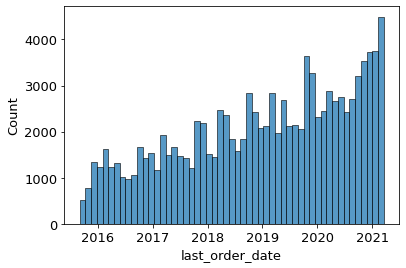

1


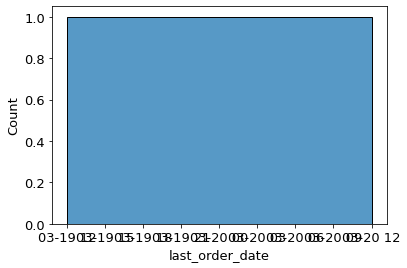

2


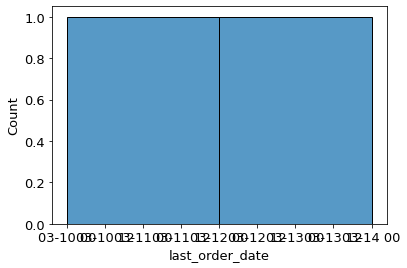

3


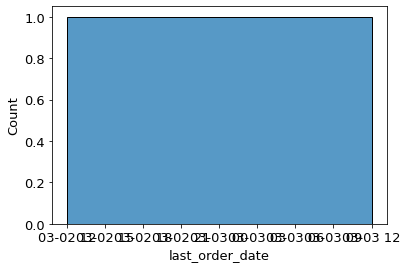

4


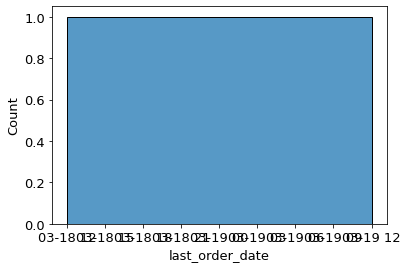

5


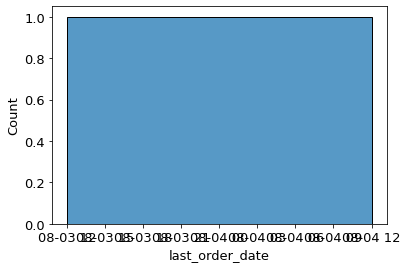

6


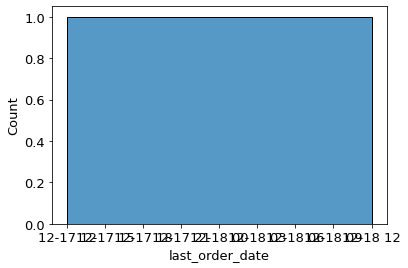

7


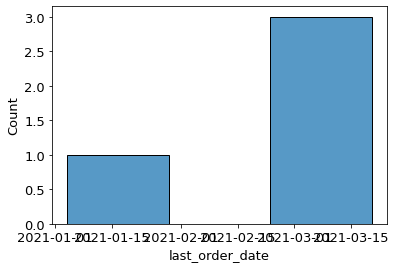

8


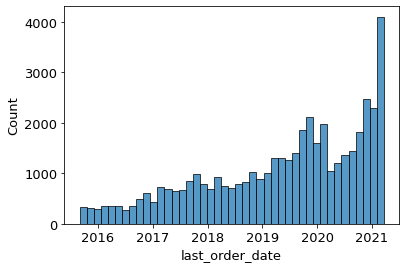

9


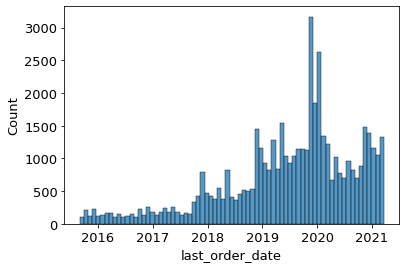

10


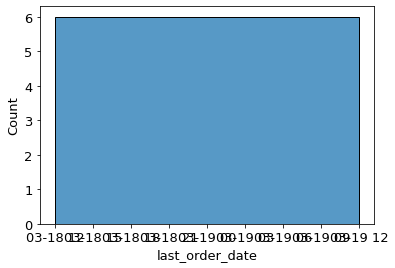

11


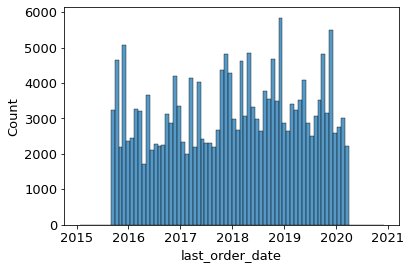

12


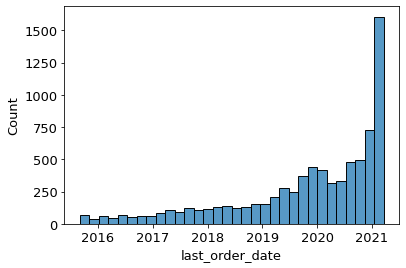

time: 3.88 s (started: 2021-07-13 12:22:45 -07:00)


In [15]:
for name, df in rfm_pre_covid.groupby('segments'):
    print(name)
    sns.histplot(df['last_order_date'])
    plt.show()

In [16]:
rfm_pre_covid['clean_emails'] =  rfm_pre_covid['nt_emails'].str.split(',').str[0].dropna()

time: 662 ms (started: 2021-07-13 12:22:49 -07:00)


In [ ]:
# segment 8 is the re-segmented at-risk cluster
rfm_pre_covid[rfm_pre_covid['segments']==8][['clean_emails', 'last_order_date']
                                            ].dropna().to_csv('at_risk_emails_last_order_date.csv',
                                                             index=False)

In [17]:
#checking null emails from rfm data
(rfm_pre_covid[rfm_pre_covid['segments']==8].shape, 
    rfm_pre_covid[rfm_pre_covid['segments']==8]['nt_emails'].isna().sum())

((45622, 95), 5004)

time: 156 ms (started: 2021-07-13 12:22:50 -07:00)


In [18]:
#some segments have very small # of customers
rfm_pre_covid['segments'].value_counts()

11    198492
0     110644
9      49250
8      45622
12      7833
10         6
7          4
2          2
1          1
3          1
4          1
5          1
6          1
Name: segments, dtype: int64

time: 6.26 ms (started: 2021-07-13 12:22:51 -07:00)


In [19]:
rfm_pre_covid[rfm_pre_covid['segments']==8]['nt_emails'].isin(hm['EMAIL']).sum()

1835

time: 43.4 ms (started: 2021-07-13 12:22:52 -07:00)


In [20]:
hm_at_risk = hm[hm['EMAIL'].isin(rfm_pre_covid[rfm_pre_covid['segments']==8]['nt_emails'])]

time: 38.9 ms (started: 2021-07-13 12:22:53 -07:00)


## Revenue Calculations from a single Campaign for Resegmented At-Risk Customers

In [21]:
#order rate from send & order rate from click for at risk
hm_at_risk['ORDERS'].sum()/hm_at_risk['SENDS'].sum(), hm_at_risk['ORDERS'].sum()/hm_at_risk['CLICKS'].sum()

(0.011162081976200458, 0.1332851985559567)

time: 2.57 ms (started: 2021-07-13 12:22:54 -07:00)


In [22]:
#order rate from send & order rate from click for general population
hm['ORDERS'].sum()/hm['SENDS'].sum(), hm['ORDERS'].sum()/hm['CLICKS'].sum()

(0.01460040267330332, 0.19415805962795282)

time: 2.68 ms (started: 2021-07-13 12:22:55 -07:00)


In [23]:
hm['ORDERS'].sum(), hm['SENDS'].sum(), hm['CLICKS'].sum(), hm.shape[0]

(20885, 1430440, 107567, 17479)

time: 2.1 ms (started: 2021-07-13 12:23:00 -07:00)


In [24]:
hm_email_at_risk =  hm_email[hm_email['EMAIL'].isin(rfm_pre_covid[rfm_pre_covid['segments']==8]['nt_emails'])]

time: 159 ms (started: 2021-07-13 12:23:00 -07:00)


In [26]:
hm_email_at_risk_merged = hm_email_at_risk.merge(hm, how='left', on='EMAIL')

time: 17.5 ms (started: 2021-07-13 12:23:16 -07:00)


In [27]:
hm_email_at_risk_merged

,EMAIL,NUM_SENDS,NUM_CLICKS,NUM_OPENS,SENDS,ORDERS,CLICKS,OPENS
0,jacastaneda@me.com,241,19,0,NaN,NaN,NaN,NaN
1,robgaertner@mac.com,63,4,0,NaN,NaN,NaN,NaN
2,la1060@hotmail.com,187,3,0,NaN,NaN,NaN,NaN
3,honeyberk@gmail.com,333,17,0,325.00000,1.00000,17.00000,0.00000
4,chrismulhern84@gmail.com,348,5,0,338.00000,1.00000,5.00000,0.00000
...,...,...,...,...,...,...,...,...
22644,cmacfoto@aol.com,1,0,0,NaN,NaN,NaN,NaN
22645,heather@wright-arch.com,1,0,0,NaN,NaN,NaN,NaN
22646,john.mielke@hq.dhs.gov,1,0,0,NaN,NaN,NaN,NaN
22647,dan@mjsdesigngroup.com,1,0,0,NaN,NaN,NaN,NaN


time: 11.7 ms (started: 2021-07-13 12:23:17 -07:00)


In [28]:
hm_email_at_risk_merged['EMAIL'].nunique()

22649

time: 11.7 ms (started: 2021-07-13 12:23:17 -07:00)


In [53]:
(hm_email_at_risk_merged['NUM_SENDS'].sum(), hm_email_at_risk_merged['ORDERS'].sum(),
 hm_email_at_risk_merged['NUM_CLICKS'].sum(),
hm_email_at_risk_merged['ORDERS'].sum()/hm_email_at_risk_merged['NUM_SENDS'].sum(),
hm_email_at_risk_merged['ORDERS'].sum()/hm_email_at_risk_merged['NUM_CLICKS'].sum(),
hm_email_at_risk_merged['NUM_CLICKS'].sum()/hm_email_at_risk_merged['NUM_SENDS'].sum())

(1832357,
 2769.0,
 80123,
 0.0015111684022272953,
 0.034559364976348865,
 0.04372674102262823)

time: 4.18 ms (started: 2021-06-14 09:10:16 -07:00)


We have a .035 order rate from click for the resegmented at-risk cluster and a click rate from send of .047 (rounded to .05)

In [38]:
rfm_pre_covid[(rfm_pre_covid['segments']==8) &
              (rfm_pre_covid['last_order_date']<datetime.strptime('2020-03-15', '%Y-%m-%d')) &
              (rfm_pre_covid['last_order_date']>datetime.strptime('2018-01-01', '%Y-%m-%d'))].shape[0]

20647

time: 28.5 ms (started: 2021-07-13 12:25:51 -07:00)


There are ~20.5K customers in the resegmented at risk category that placed an order before covid (March 15, 2020) and also placed an order after 2018. This will be the audience size of our hypothetical campaign.

In [49]:
(~hm_email_at_risk_merged['ORDERS'].isna()).sum()

1771

time: 2.4 ms (started: 2021-06-14 09:05:29 -07:00)


Only 1771 of the ~46K total customers in the at-risk cateogry have actually placed an order from an email. Our calculations are likely based upon this small sample